In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# DeepTrack 2.0 - Introduction

This tutorial gives an overview of how to use DeepTrack 2.0.

### What is DeepTrack 2.0?

DeepTrack 2.0 is a software that provides a comprehensive framework for digital microscopy enhanced by deep learning. Possible applications include particle identification, particle tracking, image segmentation, and cell counting. This tutorial focuses on the simple task to track a particle.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import image


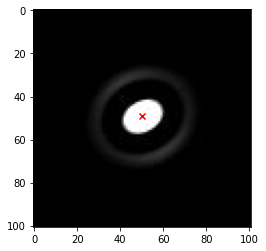

In [3]:
# Load in single image
img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# Convert to DeepTrack 2.0 Feature
img_data = dt.features.Dataset(img_data)
output_image = img_data.resolve()

# Display image
plt.imshow(output_image)

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset)

label = dataset[0]

# Plot single image against label position
plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

Finished loading all images


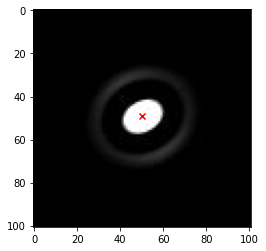

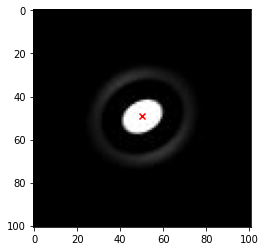

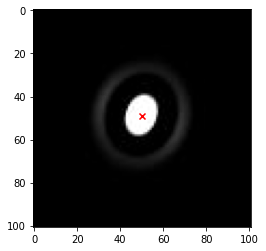

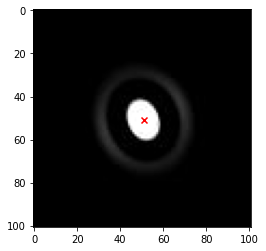

<ipython-input-4-84dbb33f30cc>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_images = np.array(all_images)


In [4]:
# ==========================================
# Load in all images
NUM_OF_IMAGES = 1000
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
#     print("Loading in an image named", image_name)
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)

print("Finished loading all images")

img_data = all_images[0]
img_data = dt.features.Dataset(img_data)

output_image = img_data.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.show()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")

# ==========================================
# Sample a few points to show the true label
chosen = [0, 6, 266, 977]
for i in chosen:
    # Select image plot
    img_data = all_images[i]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    
    # Display image grayscale
    plt.imshow(np.squeeze(output_image), cmap='gray')
    
    # Load in label for selected data
    label = dataset[i]
    # print(label)

    # Show image with true label
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
    plt.show()

# The generator part
for i in range(0, len(all_images)):
    img_data = all_images[i] #all_images[0]
    label = dataset[i]
    img_data = dt.features.Dataset(img_data)
    img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
    # print(img_data.properties)
    all_images[0] = img_data
all_images = np.array(all_images)


In [5]:
# tmpall_images = np.zeros(NUM_OF_IMAGES, dtype='float64')
# for i in range(0, NUM_OF_IMAGES):
#     image_name = 'image' + str(i + 1) + '.jpg'
# #     print("Loading in an image named", image_name)
#     img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
#     tmpall_images[i] = img_data.astype('float64')
# tmpall_images = np.array(tmpall_images)
# print(type(tmpall_images[0]))


In [ ]:

print("Making the microscope")
fluorescence_microscope = dt.Fluorescence(
    NA=0.7,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

microscope = dt.optics.Microscope(all_images, fluorescence_microscope)
print("Finished the microscope")

def get_position_of_point(image):
    return image.get_property("position")

model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    number_of_outputs=2
)
print("Model summary:")
model.summary()


## TODO, rather than using generator, use already existing sample images to train on
print("Making the Generator")
generator = dt.generators.ContinuousGenerator(
    all_images[0], 
    get_position_of_point, 
    batch_size=4,
    min_data_size=10,
    max_data_size=50
)
print("Generator Created, beginning model fitting")

print("Fitting the model")
with generator:
    model.fit(
        generator,
        epochs=30
    )

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.4/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python@3.9/3.9.4/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/site-packages/deeptrack/generators.py", line 321, in _continuous_get_training_data
    new_image = self._get(self.feature, self.feature_kwargs)
  File "/usr/local/lib/python3.9/site-packages/deeptrack/generators.py", line 366, in _get
    features.update()
  File "/usr/local/lib/python3.9/site-packages/deeptrack/features.py", line 241, in update
    self._update(**kwargs)
  File "/usr/local/lib/python3.9/site-packages/deeptrack/features.py", line 245, in _update
    self.properties.update(**kwargs)
  File "/usr/local/lib/python3.9/site-packages/deeptrack/propert

Making the microscope
Finished the microscope
Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 101, 101, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 51, 51, 32)        0         
_________________________________________________________________
